# A Distributional Perspective on Reinforcement Learning

 이 jupyter notebook은 논문 [A Distributional Perspective on Reinforcement Learning](https://arxiv.org/abs/1707.06887)의 알고리즘 (C51)을 gym의 Cartpole 환경에서 구현한 notebook 입니다. 본 notebook의 경우 알고리즘의 구현에 관련된 설명 위주로 할 예정입니다. 논문에 대한 더 자세한 내용은 readme를 참고해주세요!!

## 1. 라이브러리 불러오기

본 알고리즘의 구현을 위한 라이브러리들을 불러오는 부분입니다. 

In [1]:
# built-in
import math
import os
import random
import time
from collections import deque
from copy import deepcopy

#tihrd party
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

## 2. 파라미터 설정

알고리즘의 구현을 위한 파라미터들을 설정하는 부분입니다.<br>
C51이 [Deep Q Network](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)에 비해 추가되는 파라미터는 support와 관련된 것들입니다.<br>

Supports는 각각이 value를 의미합니다. <br>
그리고 해당 support가 가지는 값은 해당 support의 값을 받을 확률을 나타냅니다. <br>
그리고 이 모든 support와 그 값들의 기대값이 Q값이 됩니다. <br>


다음의 3가지 파라미터들을 설정해주어야 합니다.
- $N$: Support의 수
- $V_{min}$: Support의 최소값
- $V_{max}$: Support의 최대값

해당 파라미터들에 대한 설명은 다음과 같습니다. <br>

<center>
    <img src="https://github.com/reinforcement-learning-kr/distributional_rl/blob/master/1_CartPole_C51/Images/support_and_prob.png?raw=true" alt="support and probability" style="width:1000px;"/>
</center>

이외의 파라미터들에 대한 설명은 다음과 같습니다. 

In [2]:
# C51 hyperparameter
V_MAX = 10
V_MIN = -10
N_ATOMS = 51
DELTA_Z = (V_MAX - V_MIN) / (N_ATOMS - 1)

# global constant
SEED = 0
BATCH_SIZE = 32
GAMMA = 0.99
LR = 0.001
ADAM_EPS = 0.01 / BATCH_SIZE

# set device
use_cuda = torch.cuda.is_available()
print('cuda:', use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

cuda: True


## 3. 네트워크 설정

C51 알고리즘은 support들은($z_i$) 고정한 상태로 각 value를 받을 확률을($p_i$) 추정합니다. <br>
이때 다음의 그림과 같이 네트워크의 output이 각 support에 대한 값을 추정하고 이 값들을 softmax해주어 확률로 표현합니다.<br>

<center>
    <img src="https://github.com/reinforcement-learning-kr/distributional_rl/blob/master/1_CartPole_C51/Images/network_output.png?raw=true" alt="network output" style="width:800px;"/>
</center>

이 distribution은 각 action에 대해서 구해주어야합니다. 
그렇기 때문에 network의 output의 개수 -> $|A|\times N$ ($|A|$: Action의 수, $N$: support의 수)

DQN과 동일하게 network은 `일반 network`와 `target network` 2가지가 필요합니다. 

In [3]:
class DistrDQN(nn.Module):
    def __init__(self, in_dim, n_actions, n_atoms):
        super(DistrDQN, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Sequential(
            nn.Linear(64, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, n_actions * n_atoms)
        )
        self.log_softmax = nn.LogSoftmax(dim=-1)

        self.register_buffer('support', torch.arange(V_MIN, V_MAX + DELTA_Z, DELTA_Z))

    def forward(self, x):
        out = self.dense(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out).view(out.size(0), -1, N_ATOMS)
        out = self.log_softmax(out)
        probs = out.exp()

        return probs

## 4. Loss 설정 및 학습

 C51의 loss는 `target distribution`과 `추정된 distribution 중 실제 취한 action에 대한 distribution`간의 차이입니다. <br>

 원래 distributional RL의 수렴성을 확보하기 위해서는 `Wasserstein Distance`를 이용하여 두 distribution의 차이를 결정해주어야 합니다. <br>
 하지만 본 논문에서는 `Cross entropy`를 이용하여 두 distribution의 차이를 결정합니다. 
 <center>
    <img src="https://github.com/reinforcement-learning-kr/distributional_rl/blob/master/1_CartPole_C51/Images/cross_entropy_loss.png?raw=true" alt="Cross entropy loss" style="width:800px;"/>
</center>

In [4]:
def learn(net, tgt_net, rep_memory):
    net.train()
    optimizer = optim.Adam(net.parameters(), lr=LR, eps=ADAM_EPS)
    
    train_data = []
    train_data.extend(random.sample(rep_memory, BATCH_SIZE))
    
    dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, pin_memory=use_cuda)
    
    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.to(device).long()
        _s_batch = _s.to(device).float()
        rewards = r.detach().cpu().numpy()
        dones = d.detach().cpu().numpy().astype(np.bool)
        
        with torch.no_grad():
            _p_batch = tgt_net(_s_batch)
            _weights = _p_batch * tgt_net.support
            _q_batch = _weights.sum(dim=2)
            _q_batch_np = _q_batch.cpu().numpy()[0]
            _action_batch_np = np.argmax(_q_batch_np)
            _p_best = _p_batch[range(BATCH_SIZE), _action_batch_np]
            _p_best_np = _p_best.cpu().numpy()
            
        proj_p_np = projection(_p_best_np, rewards, dones)
        proj_p = torch.tensor(proj_p_np).to(device).float()
        
        p_batch = net(s_batch)
        p_acting = p_batch[range(BATCH_SIZE), a_batch.data]
        
        # cross-entropy loss
        loss = -(proj_p * (p_acting + ADAM_EPS).log()).sum(dim=1).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

## 5. 함수 설정

 이 부분은 알고리즘을 구현하는데 필요한 함수들을 구현해놓은 부분입니다. <br>
 각 함수에 대한 간단한 설명은 다음과 같습니다. 

In [5]:
def projection(next_p, rewards, dones):
    proj_p = np.zeros((BATCH_SIZE, N_ATOMS), dtype=np.float32)
    for atom in range(N_ATOMS):
        z = np.minimum(V_MAX, np.maximum(V_MIN, rewards + (V_MIN + atom * DELTA_Z) * GAMMA))
        b = (z - V_MIN) / DELTA_Z
        l = np.floor(b).astype(np.int64)
        u = np.ceil(b).astype(np.int64)

        eq_mask = u == l
        proj_p[eq_mask, l[eq_mask]] += next_p[eq_mask, atom]
        ne_mask = u != l
        proj_p[ne_mask, l[ne_mask]] += next_p[ne_mask, atom] * (u - b)[ne_mask]
        proj_p[ne_mask, u[ne_mask]] += next_p[ne_mask, atom] * (b - l)[ne_mask]

        if dones.any():
            proj_p[dones] = 0.0
            z = np.minimum(V_MAX, np.maximum(V_MIN, rewards[dones]))
            b = (z - V_MIN) / DELTA_Z
            l = np.floor(b).astype(np.int64)
            u = np.ceil(b).astype(np.int64)

            eq_mask = u == l
            eq_dones = dones.copy()
            eq_dones[dones] = eq_mask
            if eq_dones.any():
                proj_p[eq_dones, l] = 1.0

            ne_mask = u != l
            ne_dones = dones.copy()
            ne_dones[dones] = ne_mask
            if ne_dones.any():
                proj_p[ne_dones, l] = (u - b)[ne_mask]
                proj_p[ne_dones, u] = (b - l)[ne_mask]

    return proj_p

## 6. Main

 이 부분은 메인 알고리즘입니다. <br>
 진행 순서는 다음과 같습니다. 

In [6]:
# main hyperparameter
n_episodes = 200
memory_size = 10000
learn_start = 200
update_frq = 1
epsilon = 1.0
eps_min = 0.02
total_steps = 0
n_dones = 0
rewards = []
is_learned = False
is_solved = False

# make an environment
env = gym.make("CartPole-v0")
env.seed(SEED)
obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

# make two nerual networks
net = DistrDQN(obs_dim, n_actions, N_ATOMS).to(device)
target_net = deepcopy(net)

# make a replay memory
rep_memory = deque(maxlen=memory_size)

# play
for i in range(n_episodes):
    obs = env.reset()
    ep_reward = 0
    while True:
        env.render()

        # epsilon greedy
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            target_net.eval()
            with torch.no_grad():
                state = torch.tensor([obs]).to(device).float()
                probs = target_net(state)
                weights = probs * net.support
                q = weights.sum(dim=2)
                q_np = q.cpu().numpy()[0]
            action = np.argmax(q_np)

        _obs, reward, done, _ = env.step(action)
        
        rep_memory.append((obs, action, reward, _obs, done))
        
        obs = _obs
        ep_reward += reward
        total_steps += 1
        
        # learning
        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                is_learned = True
                print('\n==========  Learning Start  ==========')
            learn(net, target_net, rep_memory)
            
            # epsilon decay
            epsilon -= 1 / 10**4
            epsilon = max(eps_min, epsilon)

        if done:
            rewards.append(ep_reward)
            n_dones += 1
            print('{:3} Episode in {:5} steps, reward {:.2f}'.format(i + 1, total_steps, ep_reward))
            
            # sync target net
            if is_learned:
                if n_dones % update_frq == 0:
                    target_net.load_state_dict(net.state_dict())

            # evaluate
            if len(rewards) > 20:
                if np.mean(rewards[-21:-1]) >= 200:
                    is_solved = True
                    print('\nCartpole is sloved! {:3} Episode in {:3} steps'.format(i + 1, total_steps))
            break
    
    if is_solved:                  
        break

env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/jay/MyProject/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


  1 Episode in    14 steps, reward 14.00
  2 Episode in    26 steps, reward 12.00
  3 Episode in    38 steps, reward 12.00
  4 Episode in    58 steps, reward 20.00
  5 Episode in    83 steps, reward 25.00
  6 Episode in    93 steps, reward 10.00
  7 Episode in   111 steps, reward 18.00
  8 Episode in   123 steps, reward 12.00
  9 Episode in   134 steps, reward 11.00
 10 Episode in   149 steps, reward 15.00

==========  Learning Start  ==========
 11 Episode in   205 steps, reward 56.00
 12 Episode in   223 steps, reward 18.00
 13 Episode in   234 steps, reward 11.00
 14 Episode in   257 steps, reward 23.00
 15 Episode in   327 steps, reward 70.00
 16 Episode in   337 steps, reward 10.00
 17 Episode in   353 steps, reward 16.00
 18 Episode in   370 steps, reward 17.00
 19 Episode in   390 steps, reward 20.00
 20 Episode in   407 steps, reward 17.00
 21 Episode in   418 steps, reward 11.00
 22 Episode in   443 steps, reward 25.00
 23 Episode in   460 steps, reward 17.00
 24 Episode in   

## 7. 학습 결과

 각 에피소드에서 획득한 보상의 그래프입니다. <br>
 20회 연속으로 200점을 획득하면 CartPole을 풀었다고 가정합니다.

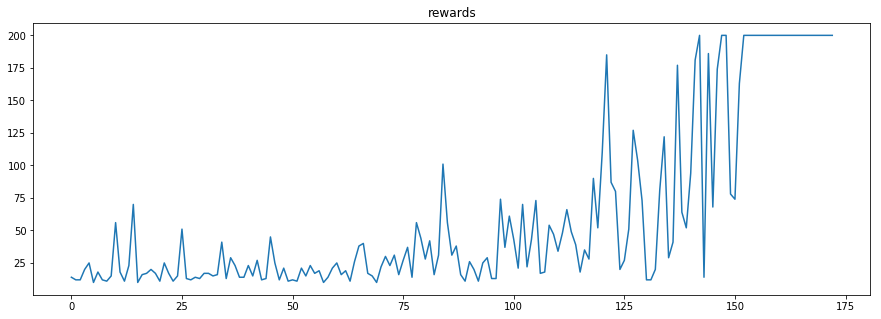

In [7]:
plt.figure(figsize=(15, 5))
plt.title('rewards')
plt.plot(rewards)
plt.show()